In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
import os
import sys
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import torch

from utils_outlier import load_nifti, load_masked_nifti, normalize_float

In [3]:
# Global variables
path_to_dir = "/analysis/ritter/data/ADNI/ADNI_BIDS_skull_stripped/" # alternative preprocessing
participant_data = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/participants.csv', delimiter = ',')

In [4]:
mask = None
remove_nan = True

In [5]:
file_names = []

In [12]:
def compute_average(path_to_dir, participant_data):
    """Normalize images, create a list and compute average"""
    i = 0
    for idx, row in participant_data.iterrows():
        path = os.path.join(path_to_dir, row["path"])
    # Use errorhandling to load files
        try:
            if mask is None:
                struct_arr = load_nifti(path)
            else:
                struct_arr = load_masked_nifti(path, mask, sess, scan_pl, mask_pl)
        except FileNotFoundError:
            print('Image not Found:', path, i)
        if remove_nan:
            struct_arr[np.where(np.isnan(struct_arr))] = 0

        # Squash between 0 and 1
        struct_arr = normalize_float(struct_arr, min=0.)
        struct_arr = struct_arr.numpy()

        # Store names and scan data
        file_names.append(os.path.join(row['SubjectID'], row['session']))
        data[i] = struct_arr
        i += 1
    return np.mean(data, axis=0)

In [47]:
def compute_norms(avg_scan, thresh, z_slice=45):
    """Calculate the norms of each image, compare to threshold and exlude outliers"""
    total_norm = 0
    fail_count = 0
    failed_scans = []
    norms = []
    for idx, sample in enumerate(data[:]):
        # Squash between 0 and 1
        struct_arr = normalize_float(sample, min=0.)
        struct_arr = struct_arr.numpy()

        # Compute norm between average and scan
        norm = np.linalg.norm(struct_arr - avg_scan, ord='fro', axis=(0,1))
        scan_norm = np.sum(norm)
        norms.append(scan_norm)

        # Test if norm is larger than threshold
        if(scan_norm > thresh):
            print('######## Fail ########')
            fail_count += 1
            failed_scans.append(file_names[idx])
            
            # Plot failed scans for inspection
            plt.figure(figsize=(10, 8))
            plt.subplot(1, 3, 1)
            plt.imshow(np.fliplr(struct_arr[:,:,z_slice]).T, cmap='gray')
            plt.subplot(1, 3, 2)
            plt.imshow(np.flip(struct_arr, axis=2)[:,z_slice,:].T, cmap='gray')
            plt.subplot(1, 3, 3)
            plt.imshow(np.fliplr(struct_arr[z_slice,:,:]).T, cmap='gray')
            plt.title('Fail for {}'.format(file_names[idx]))
        else:
            pass
        total_norm += scan_norm
        plt.show()
    print("Total failure count", fail_count)
    print('Average norm', total_norm/len(data))
    print('Standard deviation', np.std(norms))
    return failed_scans, norms

In [14]:
# Load scans and compute average scan
data = np.zeros(shape=(len(participant_data), 182, 218, 182)) 

print("Calculating average scan..")
avg_scan = compute_average(path_to_dir, participant_data)

Calculating average scan..


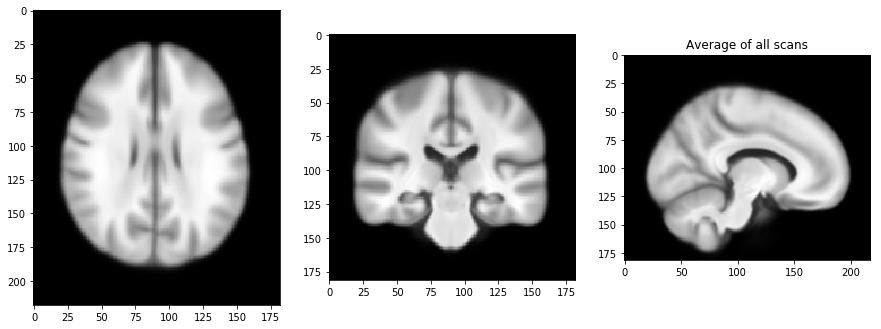

In [15]:
# Show average slices
z_slice = 100
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(np.fliplr(avg_scan[:,:,z_slice]).T, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(np.flip(avg_scan, axis=2)[:,z_slice,:].T, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(np.fliplr(avg_scan[z_slice,:,:]).T, cmap='gray')
plt.title('Average of all scans')
plt.show()

Calculating scan norms..
######## Fail ########


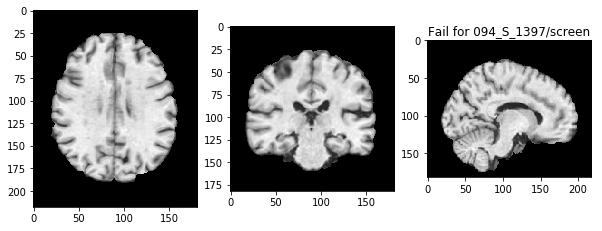

######## Fail ########


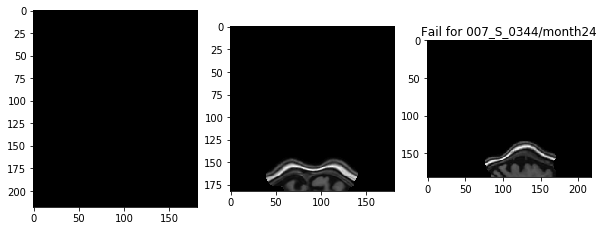

######## Fail ########


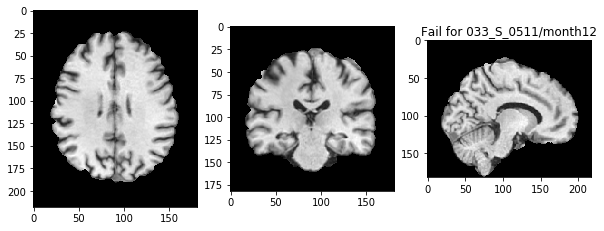

######## Fail ########


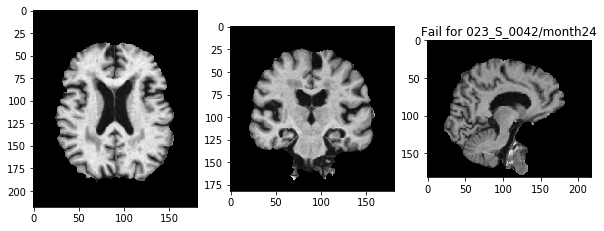

######## Fail ########


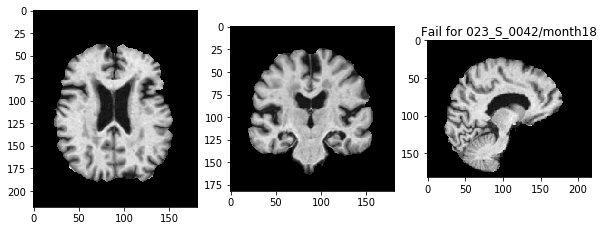

######## Fail ########


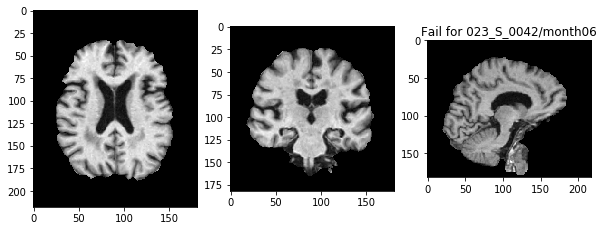

######## Fail ########


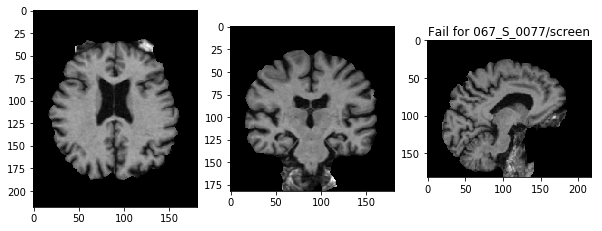

######## Fail ########


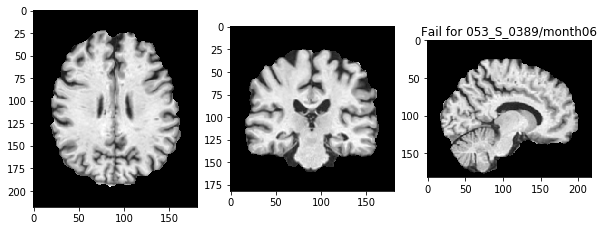

######## Fail ########


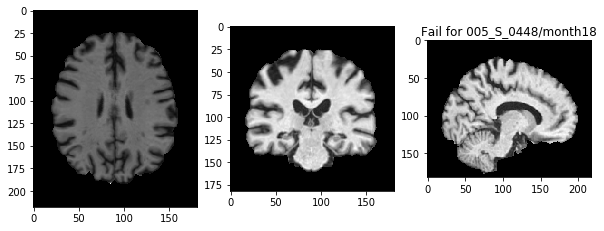

######## Fail ########


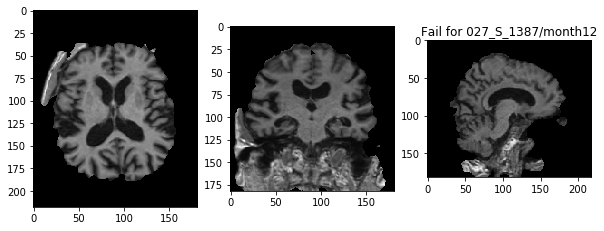

######## Fail ########


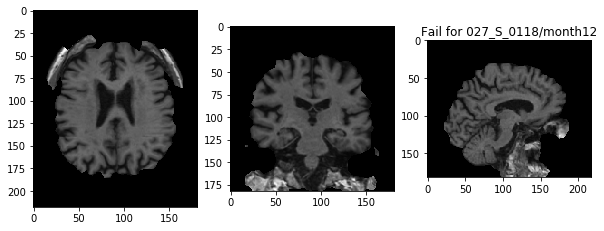

######## Fail ########


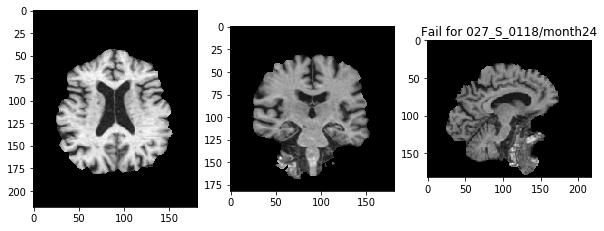

######## Fail ########


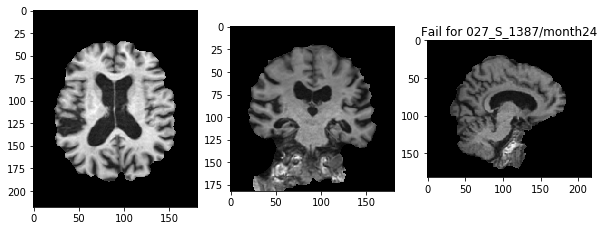

######## Fail ########


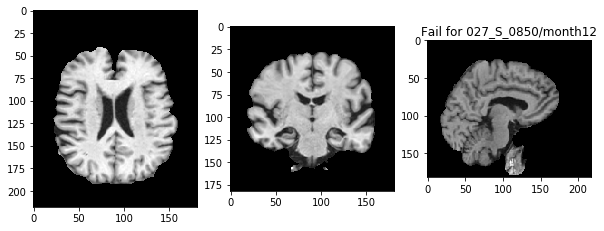

######## Fail ########


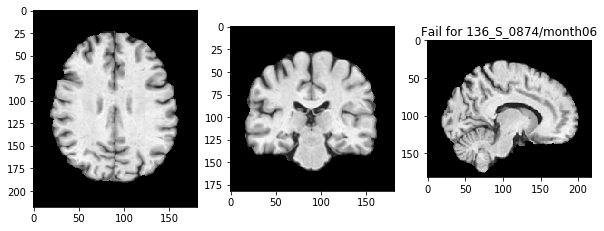

######## Fail ########


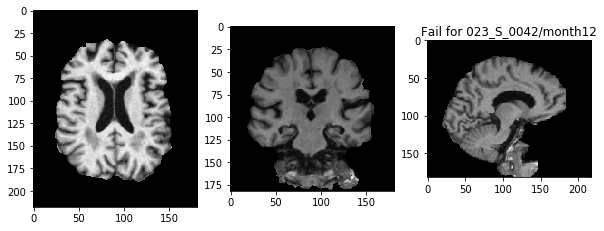

######## Fail ########


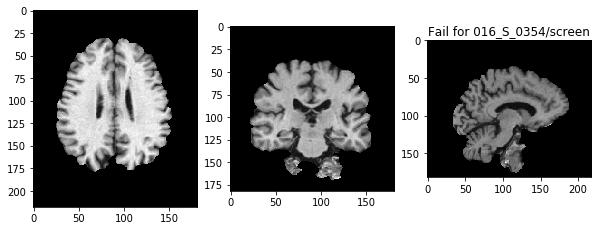

######## Fail ########


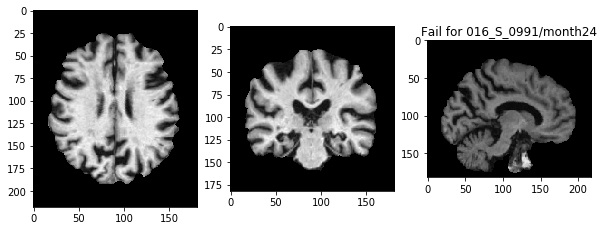

######## Fail ########


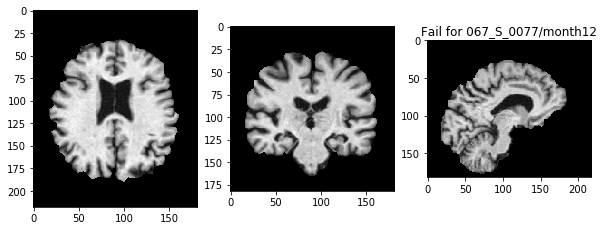

######## Fail ########


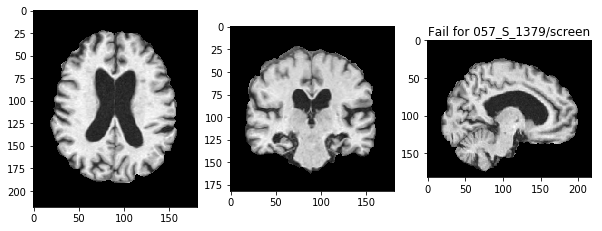

######## Fail ########


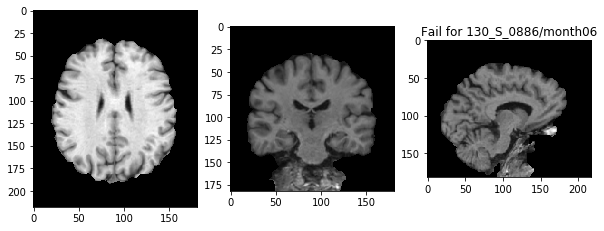

Total failure count 21
Average norm 2278.924025364852
Standard deviation 558.9056424068488
['094_S_1397/screen', '007_S_0344/month24', '033_S_0511/month12', '023_S_0042/month24', '023_S_0042/month18', '023_S_0042/month06', '067_S_0077/screen', '053_S_0389/month06', '005_S_0448/month18', '027_S_1387/month12', '027_S_0118/month12', '027_S_0118/month24', '027_S_1387/month24', '027_S_0850/month12', '136_S_0874/month06', '023_S_0042/month12', '016_S_0354/screen', '016_S_0991/month24', '067_S_0077/month12', '057_S_1379/screen', '130_S_0886/month06']


In [50]:
print("Calculating scan norms..")
# Compute norm for each scan and highlight if above threshold
thresh = 3950 # set as mean + 3 * standard deviation of the norm 
fails, norms = compute_norms(avg_scan, thresh, z_slice=100)
print(fails)

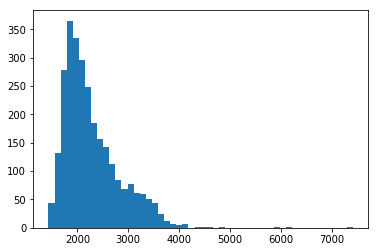

In [32]:
# Check distribution of the norms 
plt.hist(norms, bins = 50);

In [55]:
# Create dataframe with failed preprocessing to filter these out from all data 
failures_df = []
for idx, failure in enumerate(fails):
    failure = failure.split('/')
    failures_df.append(failure)
    
failed_preprocessing = pd.DataFrame(failures_df, columns = ['SubjectID', 'session'])
export_failed = failed_preprocessing.to_csv(r'/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/' + 'failed_preprocessing.csv', index = None, header = True)

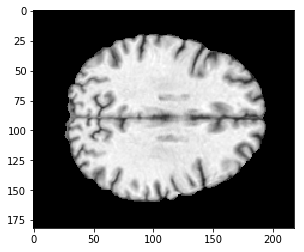

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [56]:
plt.imshow(data[0,:,:,100], cmap='gray')
plt.show()